# Resample data and concatenate channels


Here, we show how to resample different continuous data streams to be evenly sampled. We firstly import the necessary libraries and define our recording as well as output directory

In [8]:
import numpy as np
from pyneon import get_sample_data, NeonRecording

import matplotlib.pyplot as plt
import seaborn as sns

recording_dir = get_sample_data("OfficeWalk") / "Timeseries Data" / "walk1-e116e606"

Next, we will save local instances of the unprocessed data for comparison

In [9]:
recording = NeonRecording(recording_dir)
raw_gaze_data = recording.gaze.data
raw_eye_states_data = recording.eye_states.data
raw_imu_data = recording.imu.data

For imu, the effective rate is actually higher.
We can further explore this behaviour by plotting the distances between subsequent datapoints as a histogram. Dataframes can be operated upon with regular pandas logic

Text(0.010090909090909091, 100, 'IMU nominal sampling rate')

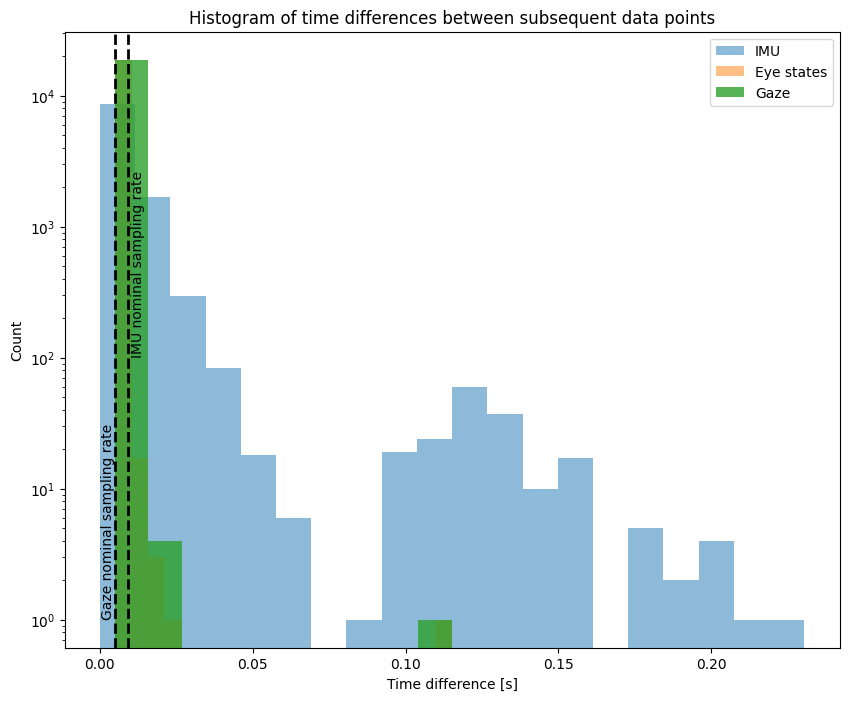

In [12]:
# Get the data points
gaze_times = raw_gaze_data["time [s]"].values
eye_state_times = raw_eye_states_data["time [s]"].values
imu_times = raw_imu_data["time [s]"].values

# Calculate the distances between subsequent data points
gaze_diffs = np.diff(gaze_times)
eye_state_diffs = np.diff(eye_state_times)
imu_diffs = np.diff(imu_times)

# Plot the differences as a histogram
plt.figure(figsize=(10, 8))
plt.hist(imu_diffs, bins=20, alpha=0.5, label="IMU")
plt.hist(eye_state_diffs, bins=20, alpha=0.5, label="Eye states")
plt.hist(gaze_diffs, bins=10, alpha=0.8, label="Gaze")
# create a logaritmic scale on the y-axis
plt.yscale("log")
plt.legend()
plt.title("Histogram of time differences between subsequent data points")
plt.xlabel("Time difference [s]")
plt.ylabel("Count")

# draw a vertical line at the nominal sampling rate, add text
plt.axvline(
    1 / recording.gaze.sampling_freq_nominal, color="k", linestyle="dashed", linewidth=2
)
plt.text(
    1 / recording.gaze.sampling_freq_nominal,
    1,
    "Gaze nominal sampling rate",
    rotation=90,
    verticalalignment="bottom",
    horizontalalignment="right",
)
plt.axvline(
    1 / recording.imu.sampling_freq_nominal, color="k", linestyle="dashed", linewidth=2
)
plt.text(
    1 / recording.imu.sampling_freq_nominal + 0.001,
    100,
    "IMU nominal sampling rate",
    rotation=90,
    verticalalignment="bottom",
    horizontalalignment="left",
)

Now, we concat the channels with a sampling frequency of 100 Hz. While this downsamples both imu and gaze, it will put them on a common reference frame. Under the hood, continuous values are linearly interpolated, whereas boolean values follow the nearest neighbour.

In [4]:
concat_df = recording.concat_streams(["gaze", "eye_states", "imu"], sampling_freq=100)

Concatenating streams:
	Gaze
	3D eye states
	IMU
Using customized sampling rate: 100 Hz ([])
Using latest start timestamp: 1725032224878547732 (['imu'])
Using earliest last timestamp: 1725032319533909732 (['imu'])


We show an exemplary sampling of eye, imu and concatenated data below. It can be seen that imu data has subsequent missing values which can in turn be interpolated

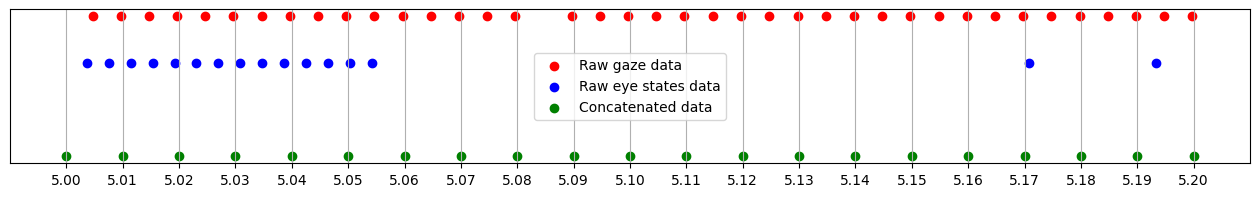

In [5]:
start_time = 5
end_time = 5.2

raw_gaze_interval = raw_gaze_data[
    (raw_gaze_data["time [s]"] >= start_time) & (raw_gaze_data["time [s]"] <= end_time)
]
raw_eye_states_interval = raw_eye_states_data[
    (raw_eye_states_data["time [s]"] > start_time)
    & (raw_eye_states_data["time [s]"] <= end_time)
]
raw_imu_interval = raw_imu_data[
    (raw_imu_data["time [s]"] >= start_time) & (raw_imu_data["time [s]"] <= end_time)
]
concat_interval = concat_df[
    (concat_df["time [s]"] >= start_time) & (concat_df["time [s]"] <= end_time)
]

# plot all data in the same scatter plot
plt.figure(figsize=(16, 2))
plt.scatter(
    raw_gaze_interval["time [s]"],
    np.zeros_like(raw_gaze_interval["time [s]"]) + 0.5,
    label="Raw gaze data",
    color="red",
)
plt.scatter(
    raw_imu_interval["time [s]"],
    np.zeros_like(raw_imu_interval["time [s]"]),
    label="Raw eye states data",
    color="blue",
)
plt.scatter(
    concat_interval["time [s]"],
    np.zeros_like(concat_interval["time [s]"]) - 1,
    label="Concatenated data",
    color="green",
)
# set x-ticks with higher frequency and add gridlines
plt.xticks(np.arange(start_time, end_time, 0.01), labels=None)
# remove x labels
# remove y-ticks
plt.yticks([])
plt.grid()
plt.legend()

A linear interpolation allows us to estimate missing values. In the end, the concatenated dataframe combines all continuous data into one central location

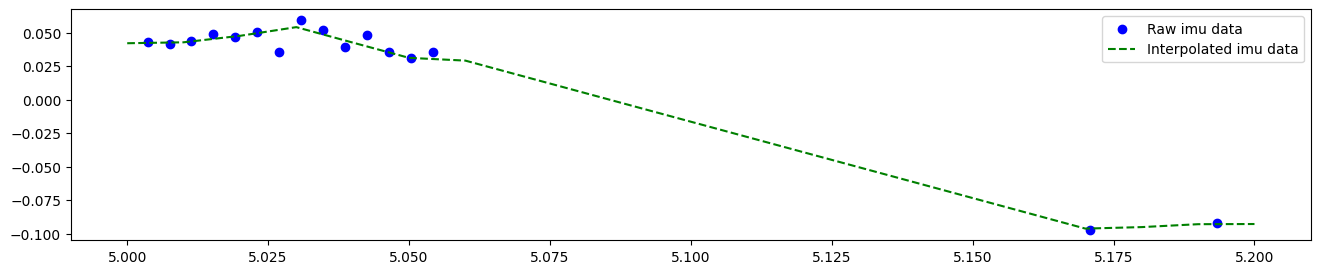

In [6]:
# plot imu data and interpolated data in same plot


plt.figure(figsize=(16, 3))
plt.scatter(
    raw_imu_interval["time [s]"],
    raw_imu_interval["acceleration x [g]"],
    label="Raw imu data",
    color="blue",
)
plt.plot(
    concat_interval["time [s]"],
    concat_interval["acceleration x [g]"],
    label="Interpolated imu data",
    color="green",
    linestyle="dashed",
)
plt.legend()